FileNotFoundError: [Errno 2] No such file or directory: '../paper_data/socio_pat_primary_school/clustersI3/clusters_primaryschool_tau_w6.300e+01_I_lin_000000_to_000129.pickle'

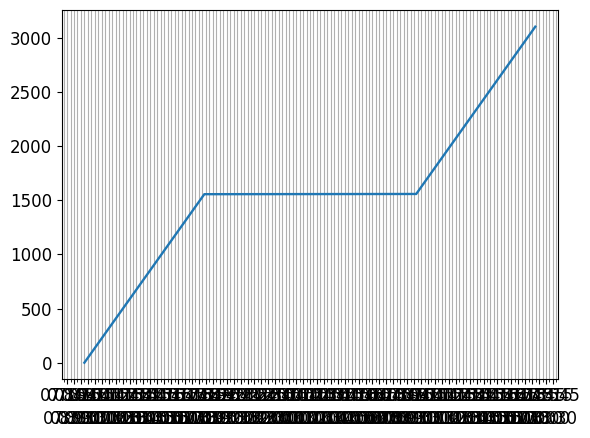

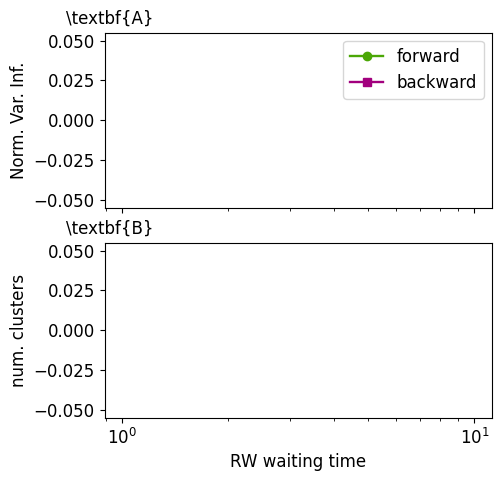

In [2]:
"""
#
# Flow stability for dynamic community detection https://arxiv.org/abs/2101.06131v2
#
# Copyright (C) 2021 Alexandre Bovet <alexandre.bovet@maths.ox.ac.uk>
#
# This program is free software; you can redistribute it and/or modify it under
# the terms of the GNU Lesser General Public License as published by the Free
# Software Foundation; either version 3 of the License, or (at your option) any
# later version.
#
# This program is distributed in the hope that it will be useful, but WITHOUT
# ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more
# details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.


analysis and plots for the dataset of the primary school (Fig. 5)
    
the clustering results are saved as `primaryschool_flow_stability_clustering.json`

"""

import os
import glob
import numpy as np
import pandas as pd
from TemporalNetwork import ContTempNetwork
from FlowStability import (norm_mutual_information, 
                               Partition, static_clustering,
                               norm_var_information)


import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
from matplotlib.colors import ListedColormap
from itertools import combinations

from datetime import timedelta, datetime

color_list =["#ffffff",
"#4ba706",
"#a2007e",
"#806dcb",
"#5eb275",
"#ca3b01",
"#01a4d6",
"#b77600",
"#a39643",
"#cc6ea9",
"#1e5e39",
"#cb5b5a"]

cmap = ListedColormap(color_list)

cmap_now = ListedColormap(color_list[1:])

#plt.style.use('alex_paper')

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1.7


datadir = '../paper_data/socio_pat_primary_school/'

clusterdir = os.path.join(datadir, 'clustersI3')
transdir = os.path.join(datadir, 'integralgrid3')

figdir = datadir

figdir_paper = datadir + 'paper_figures'

file_prefix = 'primaryschool'

net_file = os.path.join(datadir,'primaryschoolnet')

#raise Exception

#%%

transfiles = os.listdir(transdir)

files = os.listdir(clusterdir)

interval_starts = set()
interval_ends = set()
tau_ws = set()
for file in files:
    extracts = os.path.splitext(file)[0].split('_')
    interval_starts.add(int(extracts[-3]))
    interval_ends.add(int(extracts[-1]))
    for extract in os.path.splitext(file)[0].split('_'):
        if extract.startswith('w'):
            tau_ws.add(float(extract[1:]))
            
            
            
#%%% net work file

net = ContTempNetwork.load(net_file, attributes_list=['node_to_label_dict',
                      'events_table',
                      'times',
                      'time_grid',
                      'num_nodes',
                      '_overlapping_events_merged',
                      'start_date',
                      'node_label_array',
                      'male_array',
                      'female_array',
                      'node_first_start_array',
                      'node_last_end_array',
                      'node_class_array',
                      'datetimes'])


    
#%% with int_start = 0 and T
            
int_start = 0
tau_w = 20

num_intervals = len(interval_ends)



t0 = net.times[0]

tend = net.times[-1]

slice_length = 60*15 #15min



t= t0
time_slices = [t0]
while t <= tend:
    t += slice_length
    time_slices.append(t)
    


intervals = sorted(list(interval_starts))
            
int_times = [time_slices[i] for i in intervals]    
    
filt_files = []
for file in files:
    if glob.fnmatch.fnmatch(file, '*tau_w{0:.3e}_I_lin_{1:06d}_to*'.format(tau_w, int_start)):
        extracts = os.path.splitext(file)[0].split('_')
       
        filt_files.append(file)
    
    
filt_files = sorted(filt_files)

#%% plot datetimes
        
datetimes_slices = pd.date_range(start=net.start_date, end=net.datetimes.iloc[-1],
                                 freq='15min')
datetimes_intervals = [datetimes_slices[i].to_pydatetime() for i in \
                       intervals]

fig, ax = plt.subplots(1,1)
ax.plot(net.datetimes, range(len(net.datetimes)))

ax.vlines(datetimes_intervals, ymin=0, ymax=len(net.datetimes))

for x, text in zip(datetimes_intervals, intervals):
    ax.text(x, 0, str(text))

ax.xaxis.set_minor_locator(mpldates.MinuteLocator(byminute=[15,45]))
ax.xaxis.set_major_locator(mpldates.MinuteLocator(byminute=[0,30]))


                                                
ax.xaxis.grid(True, which="both")  

ax.xaxis.set_minor_formatter(mpldates.DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(mpldates.DateFormatter('\n%H:%M'))


    
#%%
        
def sort_clusters(cluster_list_to_sort, cluster_list_model):
        
    clust_similarity_lists = []
    for clust in cluster_list_to_sort:
        jaccs = []
        for class_clust in cluster_list_model:
            jaccs.append(len(clust.intersection(class_clust))/len(clust.union(class_clust)))    
        clust_similarity_lists.append(jaccs)
        
    #now sort
    clust_similarity_matrix = np.array(clust_similarity_lists)
    new_clust_order = []
    all_clusts = list(range(clust_similarity_matrix.shape[0]))
    
    while len(new_clust_order) < len(cluster_list_to_sort):
        for cla in range(clust_similarity_matrix.shape[1]):
            # loop on classes and sort according to most similar
            comm = clust_similarity_matrix[all_clusts,cla].argmax()
            if all_clusts[comm] not in new_clust_order:
                new_clust_order.append(all_clusts[comm])
        for n in new_clust_order:
            if n in all_clusts:
                all_clusts.remove(n)
                
    return [cluster_list_to_sort[i] for i in new_clust_order]

#%% choose parameters 

##all data
int_start = 0
int_stop = 129

#first day 
#int_start = 0
#int_stop = 34
#
##first day lunch
#int_start = 14
#int_stop = 20

#first day mid-lunch to class
#int_start = 18
#int_stop = 24


#first day lunch to class
#int_start = 14
#int_stop = 24

    
#int_start = 20
#int_stop = 24


# plot varinf profile
varinf=[]
varinf_rev =[]
avg_nclust=[]
avg_nclust_rev =[]
best_nclust=[]
best_nclust_rev =[]

for tau in sorted(tau_ws):
    clustres = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                                  file_prefix + '_tau_w' + \
                                  '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau, 
                                                                                 int_start,
                                                                                int_stop)))
    varinf.append(clustres['nvarinf_sym'])
    best_nclust.append(len(clustres['best_cluster_sym']))
    
    avg_nclust.append(clustres['avg_nclust_sym'])
    clustres_rev = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                                  file_prefix + '_tau_w' + \
                                  '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau, 
                                                                                 int_stop,
                                                                                 int_start)))
    varinf_rev.append(clustres_rev['nvarinf_sym'])
    avg_nclust_rev.append(clustres_rev['avg_nclust_sym'])
    best_nclust_rev.append(len(clustres_rev['best_cluster_sym']))

#%% paper figure NVI


mpl.rcParams['lines.linewidth'] = 1.7
mpl.rcParams['font.size'] = 12

markersize=4

legend_fontsize = 10

fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(5,5))

ax.plot(sorted(tau_ws), varinf, 'o-', label='forward',
        color=color_list[1])
ax.plot(sorted(tau_ws), varinf_rev,'s-', label='backward',
        color=color_list[2])
ax.set_xscale('log')
ax.set_ylabel('Norm. Var. Inf.')
ax2.plot(sorted(tau_ws), best_nclust, 'o-', label='forward',
         color=color_list[1])
ax2.plot(sorted(tau_ws), best_nclust_rev,'s-', label='backward',
         color=color_list[2])
ax2.set_xscale('log')
ax2.set_xlabel(r'RW waiting time')
ax2.set_ylabel('num. clusters')
ax.legend()

ax.text(-0.1,1.05, r'\textbf{A}', transform=ax.transAxes)
ax2.text(-0.1,1.05, r'\textbf{B}', transform=ax2.transAxes)

#%%
plt.savefig(os.path.join(figdir_paper,'school_NVI.pdf'))
plt.savefig(os.path.join(figdir_paper,'school_NVI.png'),dpi=600)
#%% load forward and backward partitions

tau_w = 63
# tau_w = 3600

# find active nodes during this time:
active_nodes = set(net.events_table.loc[np.logical_and(\
               net.events_table.starting_times >= time_slices[int_start], 
               net.events_table.ending_times < time_slices[int_stop])].source_nodes.tolist())
    
active_nodes.update(net.events_table.loc[np.logical_and(\
               net.events_table.starting_times >= time_slices[int_start], 
               net.events_table.ending_times < time_slices[int_stop])].target_nodes.tolist())

clustres = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                              file_prefix + '_tau_w' + \
                              '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau_w, 
                                                                             int_start,
                                                                             int_stop)))
clustres_rev = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                              file_prefix + '_tau_w' + \
                              '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau_w, 
                                                                             int_stop,
                                                                             int_start)))

    
#%% plot node_class vs communities plot

sortorder = np.argsort(net.node_class_array)
sorted_class_array = net.node_class_array[sortorder]


sorted_active_nodes = [n for n in sortorder if n in active_nodes]
sorted_active_nodes_class = net.node_class_array[sorted_active_nodes]
unique_class_array = np.unique(sorted_active_nodes_class)

#class sizes taking into account only active nodes
classes_size = {cla : (sorted_active_nodes_class == cla).sum() for cla in unique_class_array}
classes_size_list = [(sorted_active_nodes_class == cla).sum() for cla in unique_class_array]
assert sum(classes_size_list) == len(active_nodes)

yticks = np.cumsum(classes_size_list) - classes_size_list[0]//2
yticks_labels = np.unique(sorted_class_array)

class_2_number ={cla : i+1 for i, cla in enumerate(unique_class_array)}

# sort the two partition in the same way = similuraty with class partition
class_cluster_list = []
for clas in unique_class_array:
    class_cluster_list.append(set([n for n in active_nodes if net.node_class_array[n] == clas]))

# partitions with only active nodes
best_part = Partition(len(active_nodes), [clust.intersection(active_nodes) for \
                                      clust in clustres['best_cluster_sym']])
best_part = Partition(len(active_nodes), sort_clusters(best_part.cluster_list, class_cluster_list))
    
best_partrev = Partition(len(active_nodes), [clust.intersection(active_nodes) for \
                                      clust in clustres_rev['best_cluster_sym']])
best_partrev = Partition(len(active_nodes), sort_clusters(best_partrev.cluster_list, class_cluster_list))



node2comm = np.zeros((len(active_nodes), best_part.get_num_clusters()))
for i,n in enumerate(sorted_active_nodes):
    node2comm[i,best_part.node_to_cluster_dict[n]] = class_2_number[sorted_active_nodes_class[i]]


node2comm_rev = np.zeros((len(active_nodes), best_partrev.get_num_clusters()))
for  i,n in enumerate(sorted_active_nodes):
    node2comm_rev[i,best_partrev.node_to_cluster_dict[n]] = class_2_number[sorted_active_nodes_class[i]]


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13.5,6), gridspec_kw={'top':0.9, 'wspace':0.25})

ax1.imshow(node2comm, aspect='auto', cmap=cmap)

ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks_labels)
ax1.set_ylim((len(active_nodes),0))
ax1.set_xticks(range(best_part.get_num_clusters()))

ax1.set_xlabel('communities')
ax1.set_ylabel('nodes')

ax2.imshow(node2comm_rev, aspect='auto', cmap=cmap)

ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks_labels)
ax2.set_ylim((len(active_nodes),0))
ax2.set_xticks(range(best_partrev.get_num_clusters()))

ax2.set_xlabel('communities')

_ = fig.suptitle(f'{datetimes_slices[int_start].strftime("%d-%H:%M")} to {datetimes_slices[int_stop].strftime("%d-%H:%M")}, tau_w={tau_w}')

#%%
plt.savefig(os.path.join(figdir, f'nodes2comm_{datetimes_slices[int_start].strftime("%d_%Hh%M")}_to_{datetimes_slices[int_stop].strftime("%d_%Hh%M")}_tau_w={tau_w}.pdf'))
plt.savefig(os.path.join(figdir, f'nodes2comm_{datetimes_slices[int_start].strftime("%d_%Hh%M")}_to_{datetimes_slices[int_stop].strftime("%d_%Hh%M")}_tau_w={tau_w}.png'))
    
#%% make data for flow diagram

source_comms = best_part.cluster_list
target_comms = best_partrev.cluster_list
class_dict = {clas : set(net.node_array[net.node_class_array == clas]) for \
                  clas in np.unique(net.node_class_array)}

flows = []
for clas, clas_set in class_dict.items():
    for s, comm_s in enumerate(source_comms):
        for t, comm_t in enumerate(target_comms):
            val = len(clas_set.intersection(comm_s).intersection(comm_t))
            if val > 0:
                flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

df_flows = pd.DataFrame.from_dict(flows)



# df_flows.to_csv(os.path.join(datadir, f'flows_{datetimes_slices[int_start].strftime("%d_%Hh%M")}_to_{datetimes_slices[int_stop].strftime("%d_%Hh%M")}_tau_w={tau_w}.csv'))

cluster_infos = []
for s, comm_s in enumerate(source_comms):
    avg_starting_times = sum([net.node_first_start_array[n] for n in comm_s])/len(comm_s)

    avg_startdatetime = net.start_date + timedelta(seconds=avg_starting_times - net.start_time)
    
    avg_ending_times = sum([net.node_last_end_array[n] for n in comm_s])/len(comm_s)

    avg_enddatetime = net.start_date + timedelta(seconds=avg_ending_times - net.start_time)
    
    cluster_infos.append({'id':s, 'type': 'forward', 
                          'avg_start': avg_startdatetime.strftime("Day %-d %H:%M"),
                          'avg_end': avg_enddatetime.strftime("Day %-d %H:%M"),
                          'size': len(comm_s)})
    
for t, comm_t in enumerate(target_comms):
    avg_starting_times = sum([net.node_first_start_array[n] for n in comm_t])/len(comm_t)

    avg_startdatetime = net.start_date + timedelta(seconds=avg_starting_times - net.start_time)
    
    avg_ending_times = sum([net.node_last_end_array[n] for n in comm_t])/len(comm_t)

    avg_enddatetime = net.start_date + timedelta(seconds=avg_ending_times - net.start_time)
    
    cluster_infos.append({'id':t, 'type': 'backward', 
                          'avg_start': avg_startdatetime.strftime("Day %-d %H:%M"),
                          'avg_end': avg_enddatetime.strftime("Day %-d %H:%M"),
                          'size': len(comm_t)})
    
df_clusterinfos = pd.DataFrame.from_dict(cluster_infos)

# df_clusterinfos.to_csv(os.path.join(datadir, f'clusterinfos_{datetimes_slices[int_start].strftime("%d_%Hh%M")}_to_{datetimes_slices[int_stop].strftime("%d_%Hh%M")}_tau_w={tau_w}.csv'))
  
#%% cluster infos table to latex
# these are tables S1 and S2 of the paper

df_clusterinfos.id +=1

df_clusterinfos['start_day'] = df_clusterinfos.avg_start.str[:5]
df_clusterinfos['start_hour'] = df_clusterinfos.avg_start.str[6:]
df_clusterinfos['end_day'] = df_clusterinfos.avg_end.str[:5]
df_clusterinfos['end_hour'] = df_clusterinfos.avg_end.str[6:]
print(df_clusterinfos.loc[df_clusterinfos.type == 'forward'].T.to_latex())
print(df_clusterinfos.loc[df_clusterinfos.type == 'backward'].T.to_latex())

#%% save data for sharing
res_share = []
for tau_w in tau_ws:
    clustres = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                                  file_prefix + '_tau_w' + \
                                  '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau_w, 
                                                                                 int_start,
                                                                                 int_stop)))
    clustres_rev = pd.read_pickle(os.path.join(clusterdir, 'clusters_' + \
                                  file_prefix + '_tau_w' + \
                                  '{0:.3e}_I_lin_{1:06d}_to_{2:06d}.pickle'.format(tau_w, 
                                                                                 int_stop,
                                                                                 int_start)))

    best_part = Partition(len(active_nodes), [clust.intersection(active_nodes) for \
                                          clust in clustres['best_cluster_sym']])
    best_part = Partition(len(active_nodes), sort_clusters(best_part.cluster_list, class_cluster_list))
        
    best_partrev = Partition(len(active_nodes), [clust.intersection(active_nodes) for \
                                          clust in clustres_rev['best_cluster_sym']])
    best_partrev = Partition(len(active_nodes), sort_clusters(best_partrev.cluster_list, class_cluster_list))
    
    res_share.append({'tau_w':tau_w,
                      'forward_partition': best_part.cluster_list,
                      'backward_partition': best_partrev.cluster_list,
                      'NVI_forward': clustres['nvarinf_sym'],
                      'NVI_backward': clustres_rev['nvarinf_sym']})
    
res_share.append(class_dict)

import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, set):
            return list(obj)
        return super(NpEncoder, self).default(obj)


with open('../data/primaryschool_flow_stability_clustering.json', 'w') as fopen:
    json.dump(res_share, fopen, cls=NpEncoder)
    
#%% make houlry static clustering

start_datetime = datetime(2009,10,1,9,0,0)
end_datetime = datetime(2009,10,2,17,0,0)
daterange = pd.date_range(start=start_datetime, freq='H', 
              end=end_datetime)

timerange = [(date_i - net.start_date).total_seconds() + net.start_time for date_i in daterange]

adjacencies = []
time_slices = []
for ts, te in zip(timerange[:-1], timerange[1:]):
    A = net.compute_static_adjacency_matrix(start_time=ts, 
                                            end_time=te).toarray()
    if not (A == np.zeros_like(A)).all():
        adjacencies.append((A))
        time_slices.append((ts,te))
        

num_repeat = 50

ts = np.round(np.logspace(-1,1,num=20),2)
ts = np.round(np.logspace(1,1.699,num=10),2)

#%%
static_clust_list = []

for i, A in enumerate(adjacencies):
    print(i)
    # presents, = (A.sum(1) > 0).nonzero()
    # A = A[presents,:][:,presents]
    
    static_clust_scan = dict()
    for t in ts:
        print(t)
        clusts = []
        stabs = []
        
        static_clust_scan[t] = dict()
        
        for _ in range(num_repeat):
            
            stat_clust = static_clustering(A, t=t, linearized=True)
            stat_clust.find_louvain_clustering()
    
            clusts.append(stat_clust.partition.cluster_list)
            stabs.append(stat_clust.compute_stability())
            
        static_clust_scan[t]['best_clust'] = clusts[np.argmax(stabs)]
        
        static_clust_scan[t]['nvarinf'] = np.mean([norm_var_information(c1,c2) for c1,c2 in combinations(clusts,2)])
            
        static_clust_scan[t]['avg_nclust'] = np.mean([len(c) for c in clusts])
        
    static_clust_list.append(static_clust_scan)
    


#%%
    
#pd.to_pickle(static_clust_list, os.path.join(datadir, 'static_clust_list.pickle'))

    
static_clust_list = pd.read_pickle(os.path.join(datadir, 'static_clust_list.pickle'))



    
#%% analyze hourly static clustering


ts = list(static_clust_list[0].keys())

avg_nvinf_sum = []
avg_avg_nclust = []
for t in ts:
    
    avg_nvinf_sum.append(np.mean([sc[t]['nvarinf'] for sc in static_clust_list]))
    avg_avg_nclust.append(np.mean([sc[t]['avg_nclust'] for sc in static_clust_list]))
    
    


mpl.rcParams['lines.linewidth'] = 1.7
mpl.rcParams['font.size'] = 12


fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(5,5))

ax.plot(ts, avg_nvinf_sum, 'o-',color=color_list[1])
ax.set_xscale('log')
# ax.set_xlabel('t')
ax.set_ylabel('NVI')
ax2.plot(ts, avg_avg_nclust, 'o-',color=color_list[1])
ax2.set_xscale('log')
ax2.set_xlabel('Markov time')
ax2.set_ylabel('num. clusters')
plt.legend()

ax.text(-0.1,1.05, r'\textbf{A}', transform=ax.transAxes)
ax2.text(-0.1,1.05, r'\textbf{B}', transform=ax2.transAxes)

plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'NVI_static_hourly_clustering.png'))
# plt.savefig(os.path.join(figdir, 'NVI_static_hourly_clustering.pdf'))

#%% paper figure hourly static clustering

t = 10 # minimun of  NVI
class_part = Partition(net.num_nodes,[set((net.node_class_array == clas).nonzero()[0]) \
                                      for clas in unique_class_array])

C = np.zeros((18,300))


col_height = 290
for p, part in enumerate([sc[t]['best_clust'] for sc in static_clust_list]):
    # nodes absent during this time
    absents, = (adjacencies[p].sum(1) == 0).nonzero()
    
    part = [c for c in part if len(c)>1]
    part = sort_clusters(part,class_part.cluster_list)
    num_clusts = len(part)
    num_nodes_in_part = sum(len(c) for c in part)
    
    assert num_nodes_in_part + absents.size == net.num_nodes
    
    if num_clusts > 1:
        steps = int((col_height-num_nodes_in_part)/(num_clusts-1))
    else:
        steps = 1
    
    i = 0
    for c, clust in enumerate(part):
        if len(clust) > 1:
            # reorder nodes in clust by class
            # number of nodes in each class for this clust
            clust_classes = {classe:0 for classe in range(class_part.get_num_clusters())}
            for node in clust:
                clust_classes[class_part.node_to_cluster_dict[node]] += 1
            
            for classe in range(class_part.get_num_clusters()):
                if clust_classes[classe] > 0:
                    C[p,i:i+clust_classes[classe]] = classe + 1
                    i = i+clust_classes[classe]
            
            # for n, node in enumerate(clust):
            #     C[p,i] = class_part.node_to_cluster_dict[node] + 1
            #     i += 1
            i += steps
            
    # for node in absents:
    #     C[p,i] = class_part.node_to_cluster_dict[node] + 1
    #     i += 1
            
fig, (ax,ax2) = plt.subplots(2,1, figsize=(6,7))

ax.imshow(C.T, aspect='auto', cmap=cmap,
          interpolation='none')

ax.set_xticks(np.arange(len(static_clust_list)))
ax.set_xticklabels([f'd.{d}\n{h}h' for d,h in zip([1]*9+[2]*9,list(range(9,18))*2)])
ax.set_yticks([])

ax2.imshow(np.arange(class_part.get_num_clusters()).reshape(1,11),
           cmap=cmap_now)

_= ax2.set_xticks(np.arange(class_part.get_num_clusters()))
_= ax2.set_xticklabels(unique_class_array)
ax2.set_yticks([])

plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'static_hourly_clustering.png'), dpi=900)
# plt.savefig(os.path.join(figdir, 'static_hourly_clustering.pdf'), dpi=900)
#%% multislice clustering

# make adjacencies

t0 = net.times[0]

tend = net.times[-1]

slice_length=60*15


t= t0
time_slices = [t0]
while t <= tend:
    t += slice_length
    time_slices.append(t)
    


t_starts = time_slices[:-1]
t_stops = time_slices[1:]

adjacencies = []

active_indices = []

i = 0
for ts,te in zip(t_starts,t_stops):
    A = net.compute_static_adjacency_matrix(start_time=ts, 
                                            end_time=te).toarray()
    if not (A == np.zeros_like(A)).all():
        adjacencies.append((A))
        active_indices.append(i)
    i+=1
    
#%%

import igraph as ig
    
import leidenalg as la

graphs = []
for A in adjacencies:
    g = ig.Graph()
    g.add_vertices(A.shape[0])
    g.vs['id'] = list(range(A.shape[0]))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if j > i :
                if A[i,j]>0:
                    g.add_edge(i,j, weight=A[i,j])
    graphs.append(g)




avg_weight = np.mean([A[A>0].mean() for A in adjacencies])


#%%
interslice_weight = avg_weight
resolution_parameter = 1

num_repeat = 50

res = {}


layers, interslice_layer, G_full = \
            la.time_slices_to_layers(graphs,
                            interslice_weight=interslice_weight)
            
for resolution_parameter in np.round(np.logspace(-1.5,0.5,15),3):

    print(resolution_parameter)
    if resolution_parameter not in res.keys():
        memberships = []
        for i in range(num_repeat):
            print(i)
            optimiser = la.Optimiser()
                
                           
            partitions = [la.RBConfigurationVertexPartition(H,
                                                        weights='weight',
                                      resolution_parameter=resolution_parameter)
                                for H in layers];               
            
            interslice_partition = \
                            la.RBConfigurationVertexPartition(interslice_layer, 
                                                              resolution_parameter=0,
                                                              weights='weight')
                           
            diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition],
                                                          n_iterations=2)            
                           
            memberships.append(partitions[0].membership)
            
        res[resolution_parameter] = memberships

#%%
#import pandas as pd    
#pd.to_pickle(res,os.path.join(datadir, 'multislice_results.pickle'))


#%%

res = pd.read_pickle(os.path.join(datadir, 'multislice_results_50repeats.pickle'))    

from TemporalStability import norm_var_information
from collections import Counter
from itertools import combinations

clusts = {}
nvinf = []
resos = sorted(list(res.keys()))
moscps = []
nclusts = []
best_clusters = []
best_nclusters = []

for reso in sorted(list(res.keys())):
    print(reso)
    clust_dicts = []
    for memb in res[reso]['memberships']:
        clust_dicts.append({k: c for k,c in enumerate(memb)})
    clusts[reso] = clust_dicts
    nvinf.append(np.mean([norm_var_information(c1,c2) for c1,c2 in combinations(clust_dicts,2)]))
    mosc = list(Counter(map(tuple,res[reso]['memberships'])).most_common(1)[0][0])
    best_c = res[reso]['memberships'][np.argmax(res[reso]['modularities'])]
    best_clusters.append(best_c)
    best_nclusters.append(max(best_c)+1)
    moscps.append(mosc)
    nclusts.append(max(mosc)+1)
    
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(resos, nvinf,'-o')    
ax1.set_xscale('log')
ax1.set_xlabel('resolution')
ax1.set_ylabel('NVI')
#plt.savefig(os.path.join(figdir, 'NVI_multi_slice.png'))


  
ax2.plot(resos, best_nclusters,'-o')
ax2.set_xscale('log')
ax2.set_xlabel('resolution')
ax2.set_ylabel('N. Clust')

#plt.savefig(os.path.join(figdir, 'avg_Nclust_multi_slice.png'))

#%%    
pd.to_pickle({'nvinf' : nvinf,
              'resos' : resos,
              'best_clusters' : best_clusters,
              'best_nclusters' : best_nclusters},
             os.path.join(datadir, 'multislice_results_50repeats_plots.pickle'))

#%%
multislice_results_50repeats_plots = pd.read_pickle(os.path.join(datadir, 'multislice_results_50repeats_plots.pickle'))

nvinf = multislice_results_50repeats_plots['nvinf']
resos = multislice_results_50repeats_plots['resos']
best_clusters = multislice_results_50repeats_plots['best_clusters']
best_nclusters = multislice_results_50repeats_plots['best_nclusters']

#%%

k = 8

print(resos[k])
num_nodes = net.num_nodes

num_slices = int(len(res[resos[k]]['memberships'][0])/net.num_nodes)

clust_matrix = np.array(best_clusters[k], dtype=np.float64).reshape((num_slices,num_nodes))

for s in range(num_slices):
    # remove absent nodes
    for n in np.where(adjacencies[s].sum(0) ==0)[0]:
        clust_matrix[s,n] = np.nan

import matplotlib.pyplot as plt

unique_class_array = np.unique(sorted_active_nodes_class)

#class sizes taking into account only active nodes
classes_size_list = [(sorted_active_nodes_class == cl).sum() for cl in unique_class_array ]

cls2 = [cl_size_list//2 for cl_size_list in classes_size_list]
yticks = [x-y for x,y in zip(np.cumsum(classes_size_list), cls2)]
yticks_labels = np.unique(sorted_class_array)


fig, ax = plt.subplots(figsize=(7,5))
im = ax.imshow(clust_matrix[:,sortorder].T, aspect=0.3, cmap=cmap_now)
ax.set_xlabel('time slice')
ax.set_ylabel('Node')
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.set_ylim((net.num_nodes,0))
# plt.colorbar(im)
ax.set_title(f'reso={resos[k]}')

#plt.savefig(os.path.join(figdir, f'multislice_reso={resos[k]}.png'))
#plt.savefig(os.path.join(figdir, f'multislice_reso={resos[k]}.pdf'))


#%% paper figure multilayer
mpl.rcParams['lines.linewidth'] = 1.7
mpl.rcParams['font.size'] = 12
        
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
# we will use nested gridspecs



fig = plt.figure(figsize=(5,7.5))

outergs = GridSpec(2,1,figure=fig, height_ratios=[1, 2])

gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec = outergs[0], hspace = .1)
gs2 = GridSpecFromSubplotSpec(1, 1, subplot_spec = outergs[1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1], sharex=ax0)
ax2 = plt.subplot(gs2[0])

ax0.plot(resos, nvinf,'-o',
         color=color_list[2])    
ax0.set_xscale('log')
ax0.set_ylabel('N.V.I.')


ax0.set_xticklabels([])

ax1.plot(resos, nclusts,'-o',
         color=color_list[2])
ax1.set_xscale('log')
ax1.set_xlabel('resolution')
ax1.set_ylabel('Num. clusters')

im = ax2.imshow(clust_matrix[:,sortorder].T, aspect=0.27, cmap=cmap_now)

ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks_labels)
ax2.set_ylim((net.num_nodes,0))

slice_datetimes = [net.datetimes[net.times == t_starts[i]] for i in active_indices]

hours = []
for d in slice_datetimes:
    if d.size>0:
        hours.append((d.dt.hour.values[0], d.dt.minute.values[0]))
    else:
        hours.append((np.nan,np.nan))
        
xticks = [i for i in range(num_slices) if hours[i][1]==0]

xticks = xticks[::2]

xticklabels = [f'{h}h' for i,(h,m) in enumerate(hours) if i in xticks]

ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels, fontsize=10)

ax2.vlines(34,0,242, linestyles='dashed')

ax2.set_title(f'resolution={resos[k]}')

ax0.get_yaxis().set_label_coords(-0.12,0.5)
ax1.get_yaxis().set_label_coords(-0.12,0.5)

ax0.text(-0.1,1.05, r'\textbf{A}', transform=ax0.transAxes)
ax1.text(-0.1,1.05, r'\textbf{B}', transform=ax1.transAxes)
ax2.text(-0.1,1.05, r'\textbf{C}', transform=ax2.transAxes)

#%%
plt.savefig(os.path.join(figdir_paper, f'primary_school_multislice.png'),dpi=600)
plt.savefig(os.path.join(figdir_paper, f'primary_school_multislice.pdf'),dpi=900)

#%% just NVI num_clust

mpl.rcParams['lines.linewidth'] = 1.7
mpl.rcParams['font.size'] = 12

markersize=4

legend_fontsize = 10

fig, (ax0,ax1) = plt.subplots(2,1, sharex=True, figsize=(5,5))

ax0.plot(resos, nvinf,'-o',
         color=color_list[2])    
ax0.set_xscale('log')
ax0.set_ylabel('Norm. Var. Inf.')


ax0.set_xticklabels([])

ax1.plot(resos, nclusts,'-o',
         color=color_list[2])
ax1.set_xscale('log')
ax1.set_xlabel('resolution')
ax1.set_ylabel('num. clusters')

ax0.text(-0.1,1.05, r'\textbf{A}', transform=ax0.transAxes)
ax1.text(-0.1,1.05, r'\textbf{B}', transform=ax1.transAxes)

# plt.savefig(os.path.join(figdir_paper, 'NVI_num_clust_multi_slice.pdf'))